In [1]:
import VolGANSwaps as VGS
import Inputs
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy.random as rnd
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import norm
import pandas_datareader as pd_data
from pandas_datareader import data as pdr
import yfinance as yf
from datetime import datetime
from statsmodels.tsa.stattools import acf, pacf
from scipy.interpolate import interp1d
from numpy import arange, array, exp

In [2]:
SURFACE_PATH = "data/swaption_atm_vol_full_NEW.xlsx"
DATA_PATH = "data/forward_sofr_swap_full_NEW.xlsx"

surfaces_transform, returns, tenor, tau, tenors, taus, dates_dt = VGS.SwapsData(DATA_PATH, SURFACE_PATH)
true, condition, m_in,sigma_in, m_out, sigma_out, dates_t,  tenor, tau, tenors, taus = VGS.DataPreprocesssing(DATA_PATH, SURFACE_PATH)

In [3]:
tr = 0.85
noise_dim = 32
hidden_dim = 16
device = 'cpu'
n_epochs = 10000
n_grad = 250
val = True
data_model = 'log'
lrg = 0.0001 
lrd = 0.0001 
batch_size = 100 
device = 'cpu'

true_train, true_test, condition_train, condition_test,  m_in,sigma_in, m_out, sigma_out, dates_t,  tenor, tau, tenors, taus = VGS.DataTrainTest(DATA_PATH, SURFACE_PATH, tr, data_model, device)
gen = VGS.Generator(noise_dim=noise_dim,cond_dim=condition_train.shape[2], hidden_dim=hidden_dim,output_dim=true_train.shape[2],mean_in = m_in, std_in = sigma_in, mean_out = m_out, std_out = sigma_out)
gen.to(device)

# m_disc and sigma_disc are not used in the original VolGAN, you can see in the Discriminator forward function 
# we'll preserve the forward pass for now but we can maybe incorporate these later if needed    
m_disc = torch.cat((m_in,m_out),dim=-1)
sigma_disc = torch.cat((sigma_in,sigma_out),dim=-1)

disc = VGS.Discriminator(in_dim = condition_train.shape[2] + true_train.shape[2], hidden_dim = hidden_dim, mean = m_disc, std = sigma_disc)
disc.to(device)

true_val = False
condition_val = False

gen_opt = torch.optim.RMSprop(gen.parameters(), lr=lrg)
disc_opt = torch.optim.RMSprop(disc.parameters(), lr=lrd)

criterion = nn.BCELoss()
criterion = criterion.to(device)

In [4]:
gen_filepath = 'model/generator_parameters_latest.pth'
disc_filepath = 'model/discriminator_parameters_latest.pth'

gen.load_state_dict(torch.load(gen_filepath))
disc.load_state_dict(torch.load(disc_filepath))

<All keys matched successfully>

In [4]:
# run this to load the model without training again
gen.load_state_dict(torch.load('model/generator_parameters_full.pth'))
disc.load_state_dict(torch.load('model/discriminator_parameters_full.pth'))

<All keys matched successfully>

In [5]:
df_raw = pd.read_excel(SURFACE_PATH, header=None)
multi_index = pd.MultiIndex.from_arrays([df_raw.iloc[0], df_raw.iloc[1], df_raw.iloc[2]])
multi_index.names = multi_index[0]
multi_index = multi_index[1:]

In [6]:
from pen_torch import arbitrage_penalty_batch
yield_curve = pd.read_excel("data/usd_sofr_curve_full.xlsx")
forward_swap_df = pd.read_excel("data/forward_sofr_swap_full_NEW.xlsx")
tm_df = pd.read_excel("data/forward_sofr_swap_full_NEW.xlsx") 

In [7]:
def get_all_ns_inputs_from_df(yield_curve_df):
    df = yield_curve_df.set_index("TENOR")
    outputs = {}
    for date, row in df.iloc[1:].iterrows():
        times = []
        rates = []
        for col in row.index:
            val = col[:-1]
            unit = col[-1]
            if unit == "M":
                t = float(val) / 12
            else:
                t = float(val)
            times.append(t)
            rates.append(row[col] / 100)
        times_t = torch.tensor(times, dtype=torch.float)
        rates_t = torch.tensor(rates, dtype=torch.float)
        outputs[date] = (times_t, rates_t)
    return outputs

yields = get_all_ns_inputs_from_df(yield_curve)

In [8]:
import pandas as pd
import torch
from tqdm import tqdm
from pen_torch import ns_fit, option_price_batch, arbitrage_penalty_batch

In [9]:
forward_swap_df

,MATRUITY (EXPIRY),1M,1M.1,1M.2,1M.3,1M.4,1M.5,1M.6,1M.7,1M.8,...,25Y.8,30Y,30Y.1,30Y.2,30Y.3,30Y.4,30Y.5,30Y.6,30Y.7,30Y.8
0,TERM (TENOR),1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,...,9Y,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y
1,Ticker,S0042FS 1Y1M BLC Curncy,S0042FS 2Y1M BLC Curncy,S0042FS 3Y1M BLC Curncy,S0042FS 4Y1M BLC Curncy,S0042FS 5Y1M BLC Curncy,S0042FS 6Y1M BLC Curncy,S0042FS 7Y1M BLC Curncy,S0042FS 8Y1M BLC Curncy,S0042FS 9Y1M BLC Curncy,...,S0042FS 9Y25Y BLC Curncy,S0042FS 1Y30Y BLC Curncy,S0042FS 2Y30Y BLC Curncy,S0042FS 3Y30Y BLC Curncy,S0042FS 4Y30Y BLC Curncy,S0042FS 5Y30Y BLC Curncy,S0042FS 6Y30Y BLC Curncy,S0042FS 7Y30Y BLC Curncy,S0042FS 8Y30Y BLC Curncy,S0042FS 9Y30Y BLC Curncy
2,2025-01-10 00:00:00,4.0661,4.1379,4.1364,4.1339,4.1491,4.1527,4.1593,4.1726,4.1962,...,3.7727,4.0118,3.9763,3.9358,3.8934,3.8497,3.8027,3.7535,3.7021,3.6474
3,2025-01-09 00:00:00,3.9148,3.9922,4.0277,4.0657,4.1016,4.1192,4.1407,4.1716,4.2065,...,3.8087,4.0041,3.978,3.9465,3.9107,3.8715,3.8282,3.7818,3.732,3.6784
4,2025-01-08 00:00:00,3.9364,4.0082,4.0314,4.0687,4.097,4.1133,4.1532,4.1709,4.2166,...,3.8179,4.0115,3.9849,3.953,3.918,3.8789,3.8364,3.7908,3.7413,3.6885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,2021-09-24 00:00:00,0.3139,0.9332,1.2707,1.4443,1.6065,1.6173,1.7063,1.719,1.719,...,1.595,1.5486,1.5854,1.601,1.6032,1.5983,1.5861,1.5737,1.5567,1.5393
840,2021-09-23 00:00:00,0.2978,0.962,1.2661,1.4464,1.5666,1.5745,1.6597,1.6659,1.6658,...,1.5428,1.5058,1.541,1.5541,1.5537,1.5468,1.5346,1.5221,1.5055,1.4887
841,2021-09-22 00:00:00,0.2689,0.8582,1.1376,1.2876,1.3989,1.4134,1.4921,1.4977,1.4977,...,1.4118,1.3728,1.4038,1.4154,1.4157,1.4099,1.3993,1.3883,1.3736,1.3587
842,2021-09-21 00:00:00,0.2339,0.8074,1.118,1.296,1.4582,1.4691,1.5664,1.5733,1.5733,...,1.4679,1.4169,1.4523,1.4683,1.4715,1.4675,1.4566,1.4454,1.4297,1.4137


In [10]:
# Define the grid shape as 16x9 (16 expiry values x 9 tenor values = 144 spots)
grid_shape = (16, 9)

def convert_label(s):
    s = str(s)
    if 'M' in s and 'Y' not in s:
        return float(s.replace('M',''))/12
    elif 'Y' in s:
        return float(s.replace('Y',''))
    else:
        return float(s)

cols = forward_swap_df.columns[1:]
forward_swap_tensor = torch.tensor(forward_swap_df.iloc[2][cols].astype(float).values, dtype=torch.float)
forward_swap_tensor = forward_swap_tensor.view(*grid_shape)  # shape: (16, 9)
tm_tenor = torch.tensor(forward_swap_df.iloc[0][cols].apply(convert_label).values, dtype=torch.float)
tm_tenor = tm_tenor.view(*grid_shape)
tm_maturity = torch.tensor(tm_df.iloc[2][cols].astype(float).values, dtype=torch.float)
tm_maturity = tm_maturity.view(*grid_shape)

# Flatten the grid data to obtain 144-element vectors
forward_flat = forward_swap_tensor.view(-1)   # shape: (144,)
tenor_flat = tm_tenor.view(-1)                 # shape: (144,)
maturity_flat = tm_maturity.view(-1)           # shape: (144,)
strike_flat = forward_flat.clone()             # shape: (144,)

yields = get_all_ns_inputs_from_df(yield_curve)
some_date = list(yields.keys())[0]
yield_times, yield_rates = yields[some_date]
ns_params = ns_fit(yield_times, yield_rates, lr=1e-2, n_iter=500)

n_test = true_test.shape[0]   # e.g. 116 dates
underlying_dim = true_test.shape[1]
B = 10000

time_series_prices = []
all_arb_penalties = []
time_series_surfaces = []
with torch.no_grad():
    for _ in range(B):
        noise = torch.randn((n_test, underlying_dim, noise_dim), device=device, dtype=torch.float)
        fake = gen(noise, condition_test)  # assume output shape: [n_test, feature_dim]
        surface_past_test = condition_test[:, :, 3:]
        fake_surface = torch.exp(fake[:, :, 1:] + surface_past_test)
        # fake_surface now has shape [n_test, X, 1] where X is expected to be 144, but here it's 114.
        # We need vol_batch to have 144 columns. So, adjust by padding/trimming along dim=1.
        vol_batch = fake_surface / 100.0  # current shape: [n_test, X, 1]
        vol_batch = vol_batch.squeeze(-1)   # now shape: [n_test, X]
        n_instruments = forward_flat.shape[0]  # 144
        forward_batch = forward_flat.unsqueeze(0).expand(n_test, n_instruments)
        strike_batch = strike_flat.unsqueeze(0).expand(n_test, n_instruments)
        maturity_batch = maturity_flat.unsqueeze(0).expand(n_test, n_instruments)
        tenor_batch = tenor_flat.unsqueeze(0).expand(n_test, n_instruments)
        prices_batch = option_price_batch(forward_batch, strike_batch, vol_batch,
                                          maturity_batch, tenor_batch, ns_params, delta=0.25)
        # Reshape the flat price vector into the 16x9 grid: [n_test, 16, 9]
        prices_grid = prices_batch.view(n_test, *grid_shape)
        penalties = arbitrage_penalty_batch(prices_grid)
        time_series_prices.append(prices_grid)
        all_arb_penalties.append(penalties)
        time_series_surfaces.append(fake_surface[:, :, :])
        #time_series_surfaces.append(fake_surface.view(n_test, *grid_shape))
arb_penalties_tensor = torch.stack(all_arb_penalties, dim=0)
time_series_prices_tensor = torch.cat(time_series_prices, dim=0)
#time_series_surfaces_tensor = torch.cat(time_series_surfaces, dim=0)


In [11]:
len(arb_penalties_tensor)

10000

100%|██████████| 115/115 [00:00<00:00, 1385.94it/s]


Mean mean before  0.40895274  and after reweighting  0.3772367746933647
std of means before  0.056349225  and after reweighting across time  0.0555241928482319
Mean median before  0.39771277  and median of means 0.3651614487171173


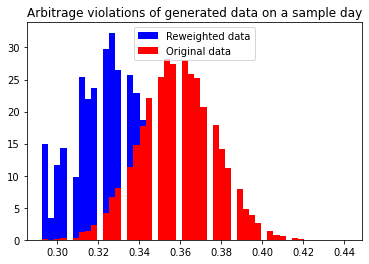

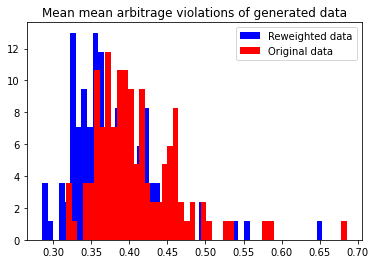

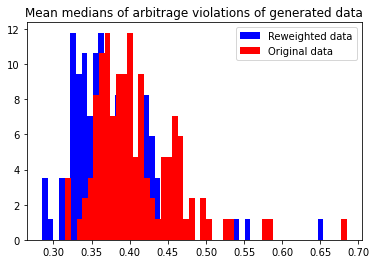

(array([[0.27756655, 0.27756655, 0.28136882, ..., 0.39923954, 0.39923954,
         0.40304184],
        [0.29277566, 0.29277566, 0.29277566, ..., 0.42205322, 0.42585552,
         0.44106463],
        [0.3878327 , 0.3878327 , 0.39163497, ..., 0.5095057 , 0.5095057 ,
         0.5209125 ],
        ...,
        [0.27756655, 0.2851711 , 0.2889734 , ..., 0.41444868, 0.41444868,
         0.41444868],
        [0.27756655, 0.2851711 , 0.2851711 , ..., 0.40304184, 0.40304184,
         0.41064638],
        [0.30038023, 0.3041825 , 0.3041825 , ..., 0.42585552, 0.4296578 ,
         0.4296578 ]], dtype=float32),
 array([[1.15288235e-02, 1.15288235e-02, 7.88231939e-03, ...,
         5.99230745e-08, 5.99230745e-08, 4.09696526e-08],
        [1.48198949e-02, 1.48198949e-02, 1.48198949e-02, ...,
         3.60074459e-08, 2.46184406e-08, 5.37943645e-09],
        [8.81795678e-03, 8.81795678e-03, 6.02889713e-03, ...,
         4.58329552e-08, 4.58329552e-08, 1.46482542e-08],
        ...,
        [3.74801233e-

In [12]:
arb_penalties_np = arb_penalties_tensor.cpu().numpy().T
df_arb = pd.DataFrame(arb_penalties_np, index=dates_t[-n_test:], columns=[str(i) for i in range(arb_penalties_np.shape[1])])

from reweighting import reweighting_stats
stats = reweighting_stats(df_arb.to_numpy(), 100)

stats

In [13]:
time_series_surfaces

[tensor([[[2.5835],
          [2.9260],
          [3.7662],
          ...,
          [2.5737],
          [3.0853],
          [3.0138]],
 
         [[1.3534],
          [2.7422],
          [4.5864],
          ...,
          [3.1391],
          [3.7505],
          [4.7054]],
 
         [[2.3122],
          [3.6352],
          [4.5755],
          ...,
          [1.0158],
          [0.9600],
          [1.1283]],
 
         ...,
 
         [[2.1615],
          [5.3161],
          [8.7939],
          ...,
          [7.8457],
          [9.4234],
          [7.0612]],
 
         [[2.2441],
          [2.4434],
          [4.6347],
          ...,
          [3.7138],
          [3.6112],
          [2.9268]],
 
         [[1.6384],
          [3.1338],
          [2.6716],
          ...,
          [1.8162],
          [2.0338],
          [1.7742]]]),
 tensor([[[ 2.6950],
          [ 2.6729],
          [ 3.2677],
          ...,
          [ 3.4878],
          [ 3.0894],
          [ 2.5828]],
 
         [[ 

In [14]:
time_series_surfaces_tensor = torch.stack(time_series_surfaces, dim=0)  # [B, n_test, 144]

time_series_surfaces_tensor = time_series_surfaces_tensor.transpose(0, 1)  # [n_test, B, 144]

weights_tensor = torch.tensor(stats[1], device=device, dtype=torch.float)
surfaces_tensor = time_series_surfaces_tensor.squeeze(-1)  # from [116, 10000, 144, 1] to [116, 10000, 144]
weights_tensor = weights_tensor.unsqueeze(-1)  # [116, 10000, 1]
final_surface = (weights_tensor * surfaces_tensor).sum(dim=1)  # [116, 144]
final_surface = final_surface.view(115, 16, 9)


In [15]:
final_surface_np = final_surface.view(n_test, -1).cpu().numpy()

index_dates = dates_t[-n_test:]
df_final_surface = pd.DataFrame(final_surface_np, index=index_dates, columns=multi_index)

df_final_surface

MATRUITY (EXPIRY)                  1M                                          \
TERM (TENOR)                       1Y                  2Y                  3Y   
Ticker            USSNAA1 ICPL Curncy USSNAA2 ICPL Curncy USSNAA3 ICPL Curncy   
Ticker                                                                          
2024-07-25                   3.085685            2.605728            3.217052   
2024-07-26                   1.554196            3.094016            3.903290   
2024-07-29                   2.783873            3.710761            4.031481   
2024-07-30                   2.390240            2.313375            2.175558   
2024-07-31                   4.023415            4.215837            3.951622   
...                               ...                 ...                 ...   
2025-01-06                   4.211161            4.430648            4.399639   
2025-01-07                   3.016068            7.721792           10.195152   
2025-01-08                   2.468671            5.202697            9.244915   
2025-01-09                   2.266617            3.120035            4.191852   
2025-01-10                   1.659176            2.529545            2.865151   

MATRUITY (EXPIRY)                                                              \
TERM (TENOR)                       4Y                  5Y                  6Y   
Ticker            USSNAA4 ICPL Curncy USSNAA5 ICPL Curncy USSNAA6 ICPL Curncy   
Ticker                                                                          
2024-07-25                   4.585783            4.410045            4.352608   
2024-07-26                   5.022972            4.198141            4.298499   
2024-07-29                   3.146140            3.113372            2.837904   
2024-07-30                   2.495457            2.606326            2.979840   
2024-07-31                   3.889464            3.408245            2.654372   
...                               ...                 ...                 ...   
2025-01-06                   3.980099            2.988966            2.989158   
2025-01-07                  13.609842            9.312587            9.140037   
2025-01-08                  14.681406           15.718426           14.414386   
2025-01-09                   4.943135            5.020403            5.047842   
2025-01-10                   3.100145            3.060813            3.076560   

MATRUITY (EXPIRY)                                                              \
TERM (TENOR)                       7Y                  8Y                  9Y   
Ticker            USSNAA7 ICPL Curncy USSNAA8 ICPL Curncy USSNAA9 ICPL Curncy   
Ticker                                                                          
2024-07-25                   5.467662            5.137790            5.110106   
2024-07-26                   4.641670            4.313135            5.014297   
2024-07-29                   2.255959            2.778769            2.027026   
2024-07-30                   3.078444            2.575435            3.062525   
2024-07-31                   2.721836            2.531319            2.337501   
...                               ...                 ...                 ...   
2025-01-06                   2.904851            2.706477            2.836594   
2025-01-07                  11.342152            9.436713            9.154418   
2025-01-08                  15.299068           15.353556           23.961811   
2025-01-09                   5.499570            5.116662            6.092343   
2025-01-10                   2.906211            2.862301            2.838236   

MATRUITY (EXPIRY)                  3M  ...                  25Y  \
TERM (TENOR)                       1Y  ...                   9Y   
Ticker            USSNAC1 ICPL Curncy  ... USSNA259 ICPL Curncy   
Ticker                                 ...                        
2024-07-25                   2.873309  ...             3.354759   
2024-07-26       

In [17]:
final_surface_np = final_surface.view(n_test, -1).cpu().numpy()

index_dates = dates_t[-n_test:]
df_final_surface = pd.DataFrame(final_surface_np, index=index_dates, columns=multi_index)

df_final_surface

MATRUITY (EXPIRY)                  1M                                          \
TERM (TENOR)                       1Y                  2Y                  3Y   
Ticker            USSNAA1 ICPL Curncy USSNAA2 ICPL Curncy USSNAA3 ICPL Curncy   
Ticker                                                                          
2024-07-25                   3.085685            2.605728            3.217052   
2024-07-26                   1.554196            3.094016            3.903290   
2024-07-29                   2.783873            3.710761            4.031481   
2024-07-30                   2.390240            2.313375            2.175558   
2024-07-31                   4.023415            4.215837            3.951622   
...                               ...                 ...                 ...   
2025-01-06                   4.211161            4.430648            4.399639   
2025-01-07                   3.016068            7.721792           10.195152   
2025-01-08                   2.468671            5.202697            9.244915   
2025-01-09                   2.266617            3.120035            4.191852   
2025-01-10                   1.659176            2.529545            2.865151   

MATRUITY (EXPIRY)                                                              \
TERM (TENOR)                       4Y                  5Y                  6Y   
Ticker            USSNAA4 ICPL Curncy USSNAA5 ICPL Curncy USSNAA6 ICPL Curncy   
Ticker                                                                          
2024-07-25                   4.585783            4.410045            4.352608   
2024-07-26                   5.022972            4.198141            4.298499   
2024-07-29                   3.146140            3.113372            2.837904   
2024-07-30                   2.495457            2.606326            2.979840   
2024-07-31                   3.889464            3.408245            2.654372   
...                               ...                 ...                 ...   
2025-01-06                   3.980099            2.988966            2.989158   
2025-01-07                  13.609842            9.312587            9.140037   
2025-01-08                  14.681406           15.718426           14.414386   
2025-01-09                   4.943135            5.020403            5.047842   
2025-01-10                   3.100145            3.060813            3.076560   

MATRUITY (EXPIRY)                                                              \
TERM (TENOR)                       7Y                  8Y                  9Y   
Ticker            USSNAA7 ICPL Curncy USSNAA8 ICPL Curncy USSNAA9 ICPL Curncy   
Ticker                                                                          
2024-07-25                   5.467662            5.137790            5.110106   
2024-07-26                   4.641670            4.313135            5.014297   
2024-07-29                   2.255959            2.778769            2.027026   
2024-07-30                   3.078444            2.575435            3.062525   
2024-07-31                   2.721836            2.531319            2.337501   
...                               ...                 ...                 ...   
2025-01-06                   2.904851            2.706477            2.836594   
2025-01-07                  11.342152            9.436713            9.154418   
2025-01-08                  15.299068           15.353556           23.961811   
2025-01-09                   5.499570            5.116662            6.092343   
2025-01-10                   2.906211            2.862301            2.838236   

MATRUITY (EXPIRY)                  3M  ...                  25Y  \
TERM (TENOR)                       1Y  ...                   9Y   
Ticker            USSNAC1 ICPL Curncy  ... USSNA259 ICPL Curncy   
Ticker                                 ...                        
2024-07-25                   2.873309  ...             3.354759   
2024-07-26       

In [18]:
n_test = true_test.shape[0]
underlying_dim = true_test.shape[1]
B = 10000

# collecting test surfaces from the generator

time_series_surfaces = []

print(f'Model: {data_model}')

with torch.no_grad():
    for l in range(B):
        #sample noise
        noise = torch.randn((n_test, underlying_dim, noise_dim), device=device,dtype=torch.float)
        #sample from the generator
        fake = gen(noise,condition_test[:,:,:])
        surface_past_test = condition_test[:,:,3:]

        #simulated implied vol surfaces as vectors
        if data_model == 'normal':
            fake_surface = fake[:,:,1:] + surface_past_test
        elif data_model == 'log':
            fake_surface = torch.exp(fake[:,:,1:] + surface_past_test)
    
        time_series_surfaces.append(fake_surface[:, 0, 0])

Model: log


In [12]:
Y1_M1_pred = pd.DataFrame(time_series_surfaces)
Y1_M1_pred = Y1_M1_pred.applymap(lambda x: x.item() if isinstance(x, torch.Tensor) else x)

In [14]:
percentile_2_5 = Y1_M1_pred.quantile(0.025).shift(1)
percentile_97_5 = Y1_M1_pred.quantile(0.975).shift(1)
#reweighted = df_final_surface.loc[:, ('1M', '1Y', 'USSNAA1 ICPL Curncy')].shift(1).tolist()

# Create a new DataFrame to store the timeseries of percentiles
percentile_df = pd.DataFrame({
    '2.5 percentile': percentile_2_5,
    '97.5 percentile': percentile_97_5,
    #'reweighted': reweighted
})

In [16]:
percentile_df.max()

2.5 percentile     2973.763568
97.5 percentile    7480.087988
dtype: float64

In [30]:
percentile_df.index = pd.to_datetime(dates_t[-n_test:])

In [31]:
percentile_df

,2.5 percentile,97.5 percentile,reweighted
Ticker,,,
2024-07-25,NaN,NaN,NaN
2024-07-26,2.205836,4.239525,3.061979
2024-07-29,1.199552,1.945400,1.548600
2024-07-30,2.031122,3.782146,2.762201
2024-07-31,1.750469,3.023200,2.354775
...,...,...,...
2025-01-06,1.624284,2.614853,2.073247
2025-01-07,3.177359,5.386695,4.170493
2025-01-08,2.358602,3.832183,3.045372


In [33]:
true_surfaces = pd.read_excel(SURFACE_PATH, header=[0,1,2], index_col=0).sort_index()

In [34]:
true_surfaces = true_surfaces.loc[dates_t[-n_test]:]

In [35]:
dates_t[-n_test:].shape

(115,)

In [36]:
dates_t

DatetimeIndex(['2021-10-21', '2021-10-22', '2021-10-25', '2021-10-26',
               '2021-10-27', '2021-10-28', '2021-10-29', '2021-11-01',
               '2021-11-02', '2021-11-03',
               ...
               '2024-12-27', '2024-12-30', '2024-12-31', '2025-01-02',
               '2025-01-03', '2025-01-06', '2025-01-07', '2025-01-08',
               '2025-01-09', '2025-01-10'],
              dtype='datetime64[ns]', name='Ticker', length=769, freq=None)

In [37]:
# get first column of the true surfaces
true_surfaces.iloc[:, 0]

2024-07-25    78.6
2024-07-26    77.5
2024-07-29    78.4
2024-07-30    81.9
2024-07-31    82.3
              ... 
2025-01-06    78.5
2025-01-07    83.5
2025-01-08    80.9
2025-01-09    79.9
2025-01-10    72.2
Name: (1M, 1Y, USSNAA1 ICPL Curncy), Length: 115, dtype: float64

In [38]:
percentile_df['true'] = true_surfaces.iloc[:, 0]

In [39]:
percentile_df

,2.5 percentile,97.5 percentile,reweighted,true
Ticker,,,,
2024-07-25,NaN,NaN,NaN,78.6
2024-07-26,2.205836,4.239525,3.061979,77.5
2024-07-29,1.199552,1.945400,1.548600,78.4
2024-07-30,2.031122,3.782146,2.762201,81.9
2024-07-31,1.750469,3.023200,2.354775,82.3
...,...,...,...,...
2025-01-06,1.624284,2.614853,2.073247,78.5
2025-01-07,3.177359,5.386695,4.170493,83.5
2025-01-08,2.358602,3.832183,3.045372,80.9


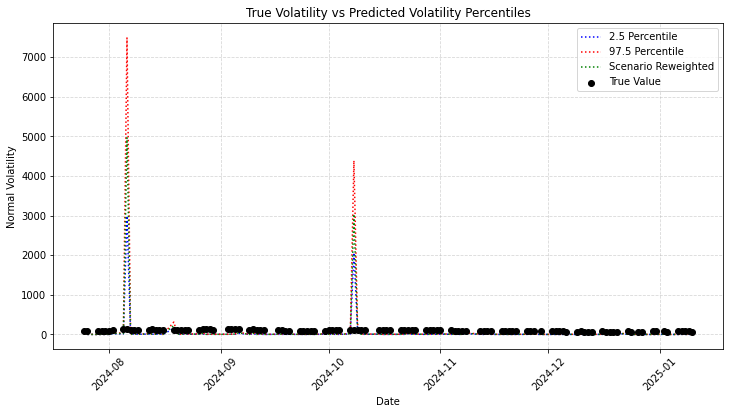

In [40]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(percentile_df.index, percentile_df["2.5 percentile"], linestyle="dotted", color="blue", label="2.5 Percentile")
plt.plot(percentile_df.index, percentile_df["97.5 percentile"], linestyle="dotted", color="red", label="97.5 Percentile")
plt.plot(percentile_df.index, percentile_df["reweighted"], linestyle="dotted", color="green", label="Scenario Reweighted")
plt.scatter(percentile_df.index, percentile_df["true"], color="black", label="True Value", zorder=3)

# Labels and Legend
plt.xlabel("Date")
plt.ylabel("Normal Volatility")
plt.title("True Volatility vs Predicted Volatility Percentiles")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)

# Show plot
plt.show()

---------------------------------------------
# ONLY STUFF ABOVE HERE SO FAR 
## Below is future testing logic
---------------------------------------------